### Задача uplift-моделирования

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

In [1]:
# !pip install scikit-uplift

In [2]:
# !pip install XGBoost

In [3]:
import numpy as np 
import pandas as pd 

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
# from catboost import CatBoostClassifier
import xgboost as xgb

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from sklearn.metrics import roc_auc_score
from sklift.viz import plot_qini_curve
from sklift.viz import plot_uplift_curve
from sklift.models import ClassTransformation
from sklift.models import TwoModels

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Загрузка данных
data = pd.read_csv('HW_data.csv')
data.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [5]:
# Переименование полей
data = data.rename(columns={'conversion': 'target', 'offer': 'treatment'})
data.tail(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
63997,6,29.99,1,0,Urban,1,Phone,Discount,0
63998,1,552.94,1,0,Surburban,1,Multichannel,Buy One Get One,0
63999,1,472.82,0,1,Surburban,0,Web,Discount,0


In [6]:
data['treatment'] = (data['treatment'] != 'No Offer').astype(int)
data.tail(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
63997,6,29.99,1,0,Urban,1,Phone,1,0
63998,1,552.94,1,0,Surburban,1,Multichannel,1,0
63999,1,472.82,0,1,Surburban,0,Web,1,0


In [7]:
# Выделение категориальных признаков
categorical_features = ['zip_code', 'channel']

data = pd.get_dummies(data, columns=categorical_features).astype(int)

data.tail(3)

,recency,history,used_discount,used_bogo,is_referral,treatment,target,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
63997,6,29,1,0,1,1,0,0,0,1,0,1,0
63998,1,552,1,0,1,1,0,0,1,0,1,0,0
63999,1,472,0,1,0,1,0,0,1,0,0,0,1


In [8]:
from sklearn.model_selection import train_test_split

# Разделение на признаки и целевую переменную
X = data.drop('target', axis=1)
y = data['target']

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
treat_train = X_train['treatment']
treat_test = X_test['treatment']
X_train.drop(columns=['treatment'], inplace=True)
X_test.drop(columns='treatment', inplace=True)

In [10]:
models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

### Одна модель с признаком коммуникации (S learner)

S-learner:
Uplift@10%: 0.08604415192650489
Uplift@20%: 0.07437101965349585


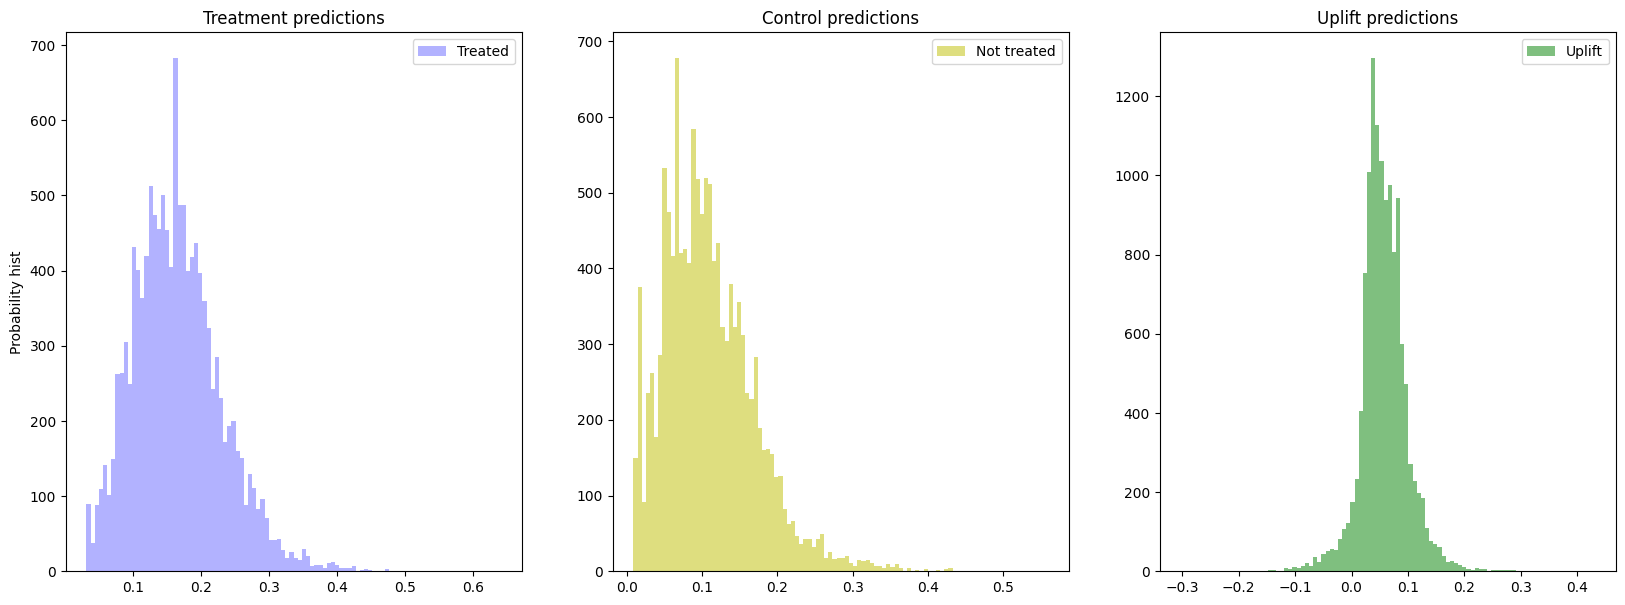

In [11]:
# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn

# Создание и обучение модели SoloModel с использованием LightGBM
sm = SoloModel(xgb.XGBClassifier(n_estimators=20, nthread=2, random_state=42, verbosity=0))
sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_test)

uplift_at_10_slearner = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1) # uplift@10%
uplift_at_20_slearner = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2) # uplift@20%

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(uplift_at_10_slearner)
models_results['uplift@20%'].append(uplift_at_20_slearner)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm.trmnt_preds_, ctrl_preds=sm.ctrl_preds_)


print("S-learner:")
print("Uplift@10%:", uplift_at_10_slearner)
print("Uplift@20%:", uplift_at_20_slearner)

### Модель с трансформацией таргета (трансформация классов)

In [12]:
ct = ClassTransformation(xgb.XGBClassifier(n_estimators=20, nthread=2, random_state=42, verbosity=0))
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_test)

uplift_at_10_ctmodel = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1) # uplift@10%
uplift_at_20_ctmodel = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2) # uplift@20%

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(uplift_at_10_ctmodel)
models_results['uplift@20%'].append(uplift_at_20_ctmodel)

# # Получение предсказаний для тритмента и контроля
# ct_trmnt_preds = ct.predict(X_test)
# ct_ctrl_preds = ct.predict(X_test)

# # Отрисуем распределения вероятностей и их разность (uplift)
# # plot_uplift_preds(trmnt_preds=ct_trmnt_preds, ctrl_preds=ct_ctrl_preds)
# plot_uplift_preds(trmnt_preds=ct_trmnt_preds, ctrl_preds=ct_ctrl_preds)

print("Class Transformation:")
print("Uplift@10%:", uplift_at_10_ctmodel)
print("Uplift@20%:", uplift_at_20_ctmodel)

Class Transformation:
Uplift@10%: 0.09787467434526259
Uplift@20%: 0.07804834623022666


### Обучение двух независимых моделей

Two Models:
Uplift@10%: 0.13053064582476348
Uplift@20%: 0.1012696021365473


array([<Axes: title={'center': 'Treatment predictions'}, ylabel='Probability hist'>,
       <Axes: title={'center': 'Control predictions'}>,
       <Axes: title={'center': 'Uplift predictions'}>], dtype=object)

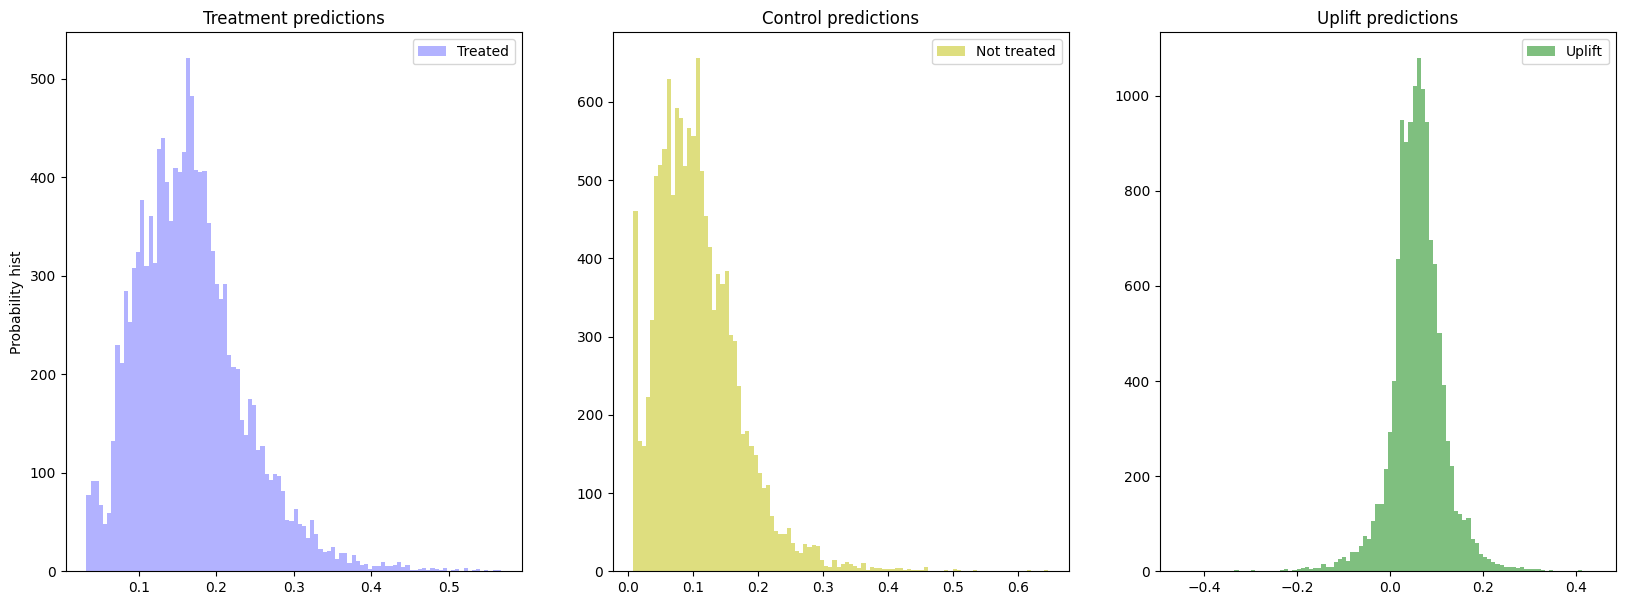

In [13]:
tm = TwoModels(
xgb.XGBClassifier(n_estimators=20, nthread=2, random_state=42, verbosity=0),
xgb.XGBClassifier(n_estimators=20, nthread=2, random_state=42, verbosity=0),
method='vanilla'  # независимые модели
)

tm.fit(X_train, y_train, treat_train)

# Получение предсказанных uplift-значений для тестовой выборки
uplift_tm = tm.predict(X_test)

# Расчет uplift@10% и uplift@20%
uplift_at_10_tm = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
uplift_at_20_tm = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)


models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(uplift_at_10_tm)
models_results['uplift@20%'].append(uplift_at_20_tm)


print("Two Models:")
print("Uplift@10%:", uplift_at_10_tm)
print("Uplift@20%:", uplift_at_20_tm)

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_)

In [14]:
pd.DataFrame(data=models_results).sort_values('uplift@10%', ascending=False)

,approach,uplift@10%,uplift@20%
2,TwoModels,0.130531,0.101270
1,ClassTransformation,0.097875,0.078048
0,SoloModel,0.086044,0.074371


## Выводы:
Данная таблица представляет оценки эффективности различных подходов к моделированию uplift, с фокусом на метриках uplift@10% и uplift@20%.

Исходя из представленных результатов:

TwoModels подход, использующий две независимые модели, показывает uplift@10% равный 0.130531 и uplift@20% равный 0.101270. Высокие значения uplift указывают на то, что TwoModels способен достичь более значимого воздействия на целевую аудиторию, по сравнению с другими рассмотренными подходами.

#### Вариант с деревом решений

In [15]:
X_train.head()

,recency,history,used_discount,used_bogo,is_referral,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
43820,4,228,0,1,0,0,1,0,0,0,1
36500,11,130,0,1,1,0,1,0,0,0,1
38039,9,29,0,1,0,1,0,0,0,0,1
1954,2,184,0,1,1,0,0,1,0,0,1
28361,9,96,1,0,0,0,1,0,0,1,0


In [ ]:
%%time
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())